<a href="https://colab.research.google.com/github/habebamostafa/Multimodal_Translation_project/blob/main/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot: A Comprehensive NLP Project

# 1. Setup and Imports

In [ ]:
 !pip install evaluate

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
import evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00


# 2. Data Loading and Preprocessing

In [ ]:
columns = ['question', 'answer']

df = pd.read_csv('/kaggle/input/chatbot-dataset/dialogs.txt', sep='\t', names=columns)

# Now df will have columns named 'question' and 'answer'
df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


# 3. Exploratory Data Analysis


Data types of columns:
question    object
answer      object
dtype: object

Shape of the dataset:
(3725, 2)

Missing values:
question    0
answer      0
dtype: int64


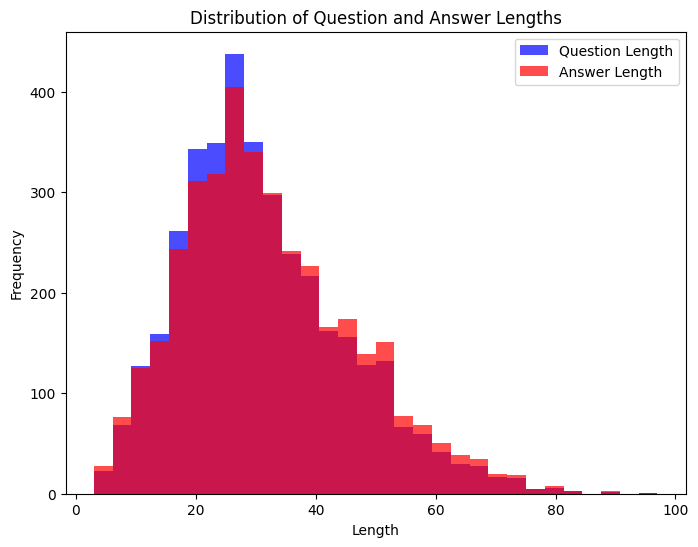

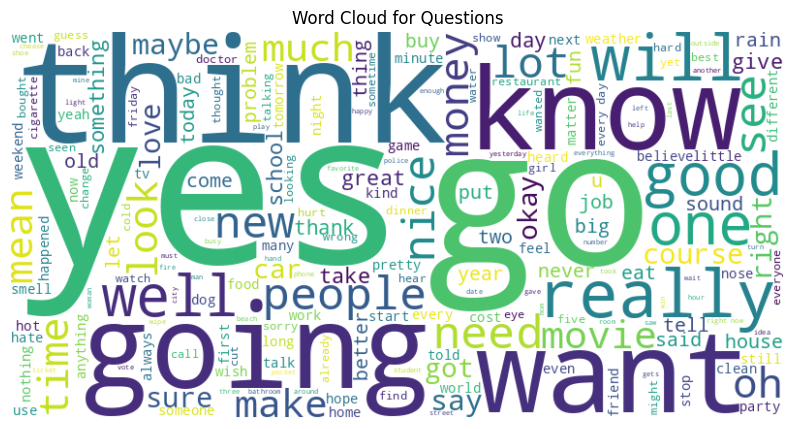

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

print("\nData types of columns:")
print(df.dtypes)
print("\nShape of the dataset:")
print(df.shape)
print("\nMissing values:")
print(df.isnull().sum())

# Length distribution of questions and answers
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

# Visualization
plt.figure(figsize=(8, 6))
plt.hist(df['question_length'], bins=30, alpha=0.7, color='blue', label='Question Length')
plt.hist(df['answer_length'], bins=30, alpha=0.7, color='red', label='Answer Length')
plt.title('Distribution of Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Word cloud for questions
question_text = ' '.join(df['question'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(question_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')
plt.show()

# 4. Topic Modeling and Language Complexity Analysis

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['question'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
# Display the top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:", ", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]))

df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

# Analyze language complexity
avg_question_word_length = df['question'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()
avg_answer_word_length = df['answer'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()

print("\nAverage word length in questions:", avg_question_word_length)
print("Average word length in answers:", avg_answer_word_length)

Topic 0: think, really, time, maybe, mean, ve, ll, better, let, doing
Topic 1: like, yes, want, didn, day, right, say, does, going, just
Topic 2: good, know, don, need, sure, course, great, job, new, haven
Topic 3: did, people, lot, school, don, today, really, yes, oh, think
Topic 4: ll, going, okay, nice, money, got, just, think, make, car

Average word length in questions: 4.166015845093442
Average word length in answers: 4.175336153968232


# 5. Adding New Dialogue Data

In [ ]:
# Define the new dialogue data
new_dialogue_data = [
    ["Hi", "Hello"],
    ["How are you?", "I'm good, thanks for asking. How about you?"],
    ["I'm doing well too.", "That's great to hear. What have you been up to lately?"],
    ["Not much, just working and spending time with family.", "That sounds nice. Have you watched any good movies recently?"],
    ["Yeah, I saw a really good one last weekend.", "It was a thriller, right? I heard good things about it."],
    ["Yes, it was.", "Do you want to watch it together sometime?"],
    ["Sure, that sounds like a plan.", "Awesome! Let's plan it for this weekend."],
    ["Sounds good to me.", "Alright then, it's a plan. What time works for you?"],
    ["How about Saturday evening?", "Perfect! Saturday evening it is. I'll book the tickets."],
    ["Great! Looking forward to it.", "Me too. It'll be fun."]
]
new_df = pd.DataFrame(new_dialogue_data, columns=columns)

# Concatenate the new DataFrame with the existing DataFrame
df = pd.concat([df, new_df], ignore_index=True)

# Print the updated DataFrame
df

,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,"hi, how are you doing?",i'm fine. how about yourself?,22.0,29.0,5.0,5.0
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,29.0,35.0,5.0,6.0
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,35.0,33.0,6.0,7.0
3,no problem. so how have you been?,i've been great. what about you?,33.0,32.0,7.0,6.0
4,i've been great. what about you?,i've been good. i'm in school right now.,32.0,40.0,6.0,8.0
...,...,...,...,...,...,...
3730,"Yes, it was.",Do you want to watch it together sometime?,NaN,NaN,NaN,NaN
3731,"Sure, that sounds like a plan.",Awesome! Let's plan it for this weekend.,NaN,NaN,NaN,NaN
3732,Sounds good to me.,"Alright then, it's a plan. What time works for...",NaN,NaN,NaN,NaN
3733,How about Saturday evening?,Perfect! Saturday evening it is. I'll book the...,NaN,NaN,NaN,NaN


# 6. Text Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,"hi, how are you doing?",i'm fine. how about yourself?,22.0,29.0,5.0,5.0
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,29.0,35.0,5.0,6.0
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,35.0,33.0,6.0,7.0
3,no problem. so how have you been?,i've been great. what about you?,33.0,32.0,7.0,6.0
4,i've been great. what about you?,i've been good. i'm in school right now.,32.0,40.0,6.0,8.0
...,...,...,...,...,...,...
3730,"yes, it was.",do you want to watch it together sometime?,NaN,NaN,NaN,NaN
3731,"sure, that sounds like a plan.",awesome! let's plan it for this weekend.,NaN,NaN,NaN,NaN
3732,sounds good to me.,"alright then, it's a plan. what time works for...",NaN,NaN,NaN,NaN
3733,how about saturday evening?,perfect! saturday evening it is. i'll book the...,NaN,NaN,NaN,NaN


# 7. Training a Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df['question'], preprocessed_df['answer'], test_size=0.2, random_state=42, shuffle=True)

Pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

Pipe.fit(X_train, y_train)

Pipe.predict(['where are you going'])[0]

# Predicting text using the pipeline on the test set
predicted_text = Pipe.predict(X_test)

# Creating a DataFrame to compare the first 10 results
comparison_df = pd.DataFrame({'Real Question ': X_test[:10],'Real Generated Text': y_test[:10], 'Predicted Text': predicted_text[:10]})
comparison_df.head(10)

,Real Question,Real Generated Text,Predicted Text
3253,how are you doing that?,i started shopping at the dollar store.,i was scratching my nose.
3190,"the pants are fine, but the pocket has a huge ...",you shouldn't carry your keys and pens in your...,you shouldn't carry pens in your pocket.
2194,uh-oh. that means that she's fat and ugly.,she's cute.,men singers don't have to look good.
3303,that's great. we won't have neighbors on both ...,no pets are allowed.,that doesn't matter. i don't want to sit around.
642,"i really wanted you to come, but i understand.","yeah, maybe next time.",i have things to do.
3214,that's a good deal.,and a one-pound tub of soft butter was the sam...,"yes, even though some of the potatoes had eyes."
184,she's one of the prettiest girls at the school.,what does she look like?,maybe we should learn some good jokes.
3515,"no, that's not the problem.",maybe it will go away in a little while.,did you need something?
3185,why not?,i didn't want to pay for the holes.,the seats and windows are dirty.
2206,eight o'clock.,that sounds great.,i have the dvd.


# 8. Visualizing Feature Importance

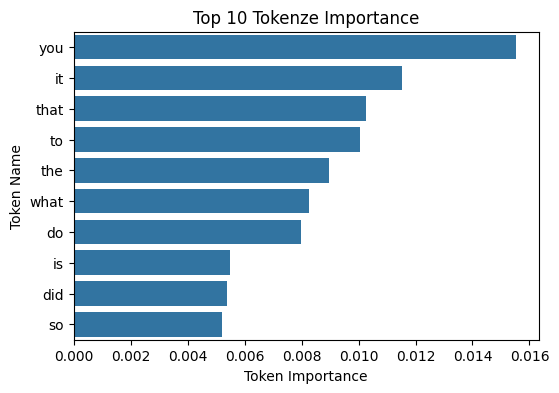

In [ ]:
import seaborn as sns

# Visualize Feature Importance
if isinstance(Pipe.named_steps['classifier'], RandomForestClassifier):
    feature_importances = Pipe.named_steps['classifier'].feature_importances_
    feature_names = Pipe.named_steps['tfidf'].get_feature_names_out()

    # Sort feature importances
    sorted_indices = feature_importances.argsort()[::-1]
    top_feature_importances = feature_importances[sorted_indices][:10]
    top_feature_names = np.array(feature_names)[sorted_indices][:10]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=top_feature_importances, y=top_feature_names)
    plt.xlabel('Token Importance')
    plt.ylabel('Token Name')
    plt.title('Top 10 Tokenze Importance')
    plt.show()

# 9. Chatbot Interaction Function

In [ ]:
# Function to get response from chatbot
def get_response(question):
    response = Pipe.predict([question])[0]
    return response

# Function to interact with the user
def chat():
    while True:
        question = input("You: ")
        if question.lower() == 'quit':
            print("Chatbot: Goodbye!")
            break
        response = get_response(question)
        print("Chatbot:", response)

# Start the chat
chat()

You: how are you?
Chatbot: i'm good, thanks for asking. how about you?
You: quit
Chatbot: Goodbye!


# 10. Sequence-to-Sequence Model with Attention

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unicodedata

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub("(\\W)"," ",text)
    text = re.sub('\S*\d\S*\s*','', text)
    text =  "<sos> " +  text + "<eos>"
    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df

# Preprocessing the data
questions = preprocessed_df['question'].values.tolist()
answers = preprocessed_df['answer'].values.tolist()

# Tokenizing the data
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(np.concatenate((questions, answers), axis=0))

vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
question_seqs = tokenizer.texts_to_sequences(questions)
answer_seqs = tokenizer.texts_to_sequences(answers)

# Padding sequences for equal length
# Pad sequences for equal length
max_len_question = max(len(seq) for seq in question_seqs)
max_len_answer = max(len(seq) for seq in answer_seqs)
max_len = max(max_len_question, max_len_answer)
print(max(max_len_question, max_len_answer))
# Pad sequences separately for questions and answers
question_seqs = pad_sequences(question_seqs, maxlen=max_len, padding='post')
answer_seqs = pad_sequences(answer_seqs, maxlen=max_len, padding='post')

tokenizer.texts_to_sequences("<sos>")

tokenizer.word_index["<sos>"]

22


1

# 11. Defining the Seq2Seq Model Architecture

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate, Dropout

# Define the model architecture
latent_dim = 256  # Dimensionality of the encoding space

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len,))
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len-1,))
decoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len-1,))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding(decoder_inputs), initial_state=encoder_states)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Add dropout layer for regularization
decoder_concat_input = Dropout(0.1)(decoder_concat_input)

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 22)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 21)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 22, 256)        │        618,496 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 21, 256)        │        618,496 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 22, 256),      │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 21, 256),      │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 21, 256)        │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 21, 512)        │              0 │ lstm_1[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 21, 512)        │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 21, 2416)       │      1,239,408 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,527,024 (13.45 MB)

 Trainable params: 3,527,024 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

# 12. Training the Seq2Seq Model

In [ ]:
# Train the model
model.fit([question_seqs, answer_seqs[:, :-1]], answer_seqs[:, 1:],
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - loss: 4.2389 - val_loss: 2.3028
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 1.9838 - val_loss: 2.2546
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 1.9445 - val_loss: 2.2353
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 1.8946 - val_loss: 2.1965
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 1.8303 - val_loss: 2.1483
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 1.7558 - val_loss: 2.1164
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 1.6993 - val_loss: 2.0982
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 1.6593 - val_loss: 2.0695
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 1.5793 - val_loss: 2.0730
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 1.5640 - val_loss: 2.0632
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 1.5113 - val_loss: 2.0705
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - lo

# 13. Generating Responses with the Seq2Seq Model

In [ ]:
# Function to generate a response given a input sentence
def generate_response(input_text):
    # Tokenize the input text
    input_sequence = tokenizer.texts_to_sequences([input_text])
    # Pad the input sequence
    input_sequence = pad_sequences(input_sequence, maxlen=max_len, padding='post')

    # Initialize the decoder input sequence with start token
    decoder_input_sequence = np.zeros((1, max_len-1))
    decoder_input_sequence[0, 0] = tokenizer.word_index['<sos>']

    # Generate response using the trained model
    for i in range(max_len - 1):
        predictions = model.predict([input_sequence, decoder_input_sequence])
        predicted_id = np.argmax(predictions[0, i, :])
        if predicted_id == tokenizer.word_index['<eos>']:
            break
        decoder_input_sequence[0, i+1] = predicted_id

    # Convert output sequence to text
    output_text = ''
    for token_index in decoder_input_sequence[0]:
        if token_index == tokenizer.word_index['<eos>'] or token_index == 0:
            break
        output_text += tokenizer.index_word[token_index] + ' '

    return output_text.strip()

# Test the function with input "how are you"
input_text = "how do you do"
response = generate_response(input_text)
print("Response:", response[5:])

def chat():
    while True:
        question = input("You: ")
        if question.lower() == 'quit':
            print("Chatbot: Goodbye!")
            break
        response = generate_response(question)
        print("Chatbot:", response)

chat()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Response:  i don t know i m not
You: quit
Chatbot: Goodbye!


# 14. Fine-tuning a Pre-trained Language Model

In [ ]:
model_name='google/flan-t5-small'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# 15. Zero-shot Inference with the Pre-trained Model

In [ ]:
index = 0

question = df['question'][index]
answer = df['answer'][index]

prompt = f"""
Answere the following question.

{question}

Answere:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=22,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN ANSWER:\n{answer}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Answere the following question.

hi, how are you doing?

Answere:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
i'm fine. how about yourself?

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ZERO SHOT:
i'm a sailor


# 16. Preparing Data for Fine-tuning

In [ ]:
def tokenize_function(row):
    start_prompt = 'Answer the following question.\n\n'
    end_prompt = '\n\nAnswer: '

    # Convert the question to a string if it's a list
    question = ' '.join(row["question"]) if isinstance(row["question"], list) else row["question"]

    prompt = start_prompt + question + end_prompt
    row['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids[0]

    # Assuming "answer" column is already a string, no need for conversion
    row['labels'] = tokenizer(row["answer"], padding="max_length", truncation=True, return_tensors="pt").input_ids[0]

    return row


# Tokenize the DataFrame
tokenized_df = df.apply(tokenize_function, axis=1)

# Convert tensors to lists
tokenized_df = tokenized_df[:-150]
tokenized_df = tokenized_df.drop(index=708)
tokenized_df['input_ids'] = tokenized_df['input_ids'].apply(lambda x: x.tolist())
tokenized_df['labels'] = tokenized_df['labels'].apply(lambda x: x.tolist())

from datasets import Dataset

# Assuming `tokenized_df` is your pandas DataFrame
dataset = Dataset.from_pandas(tokenized_df)

tokenized_datasets = dataset.map(tokenize_function, batched=True, batch_size=512)
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'answer',])

dataset.shape

dataset

Map:   0%|          | 0/3584 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'question_length', 'answer_length', 'question_word_count', 'answer_word_count', 'input_ids', 'labels', '__index_level_0__'],
    num_rows: 3584
})

# 17. Fine-tuning the Pre-trained Model

In [ ]:
output_dir = f'/kaggle/working/LLM'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=3,       # Increase the number of training epochs to 3
    weight_decay=0.01,
    logging_steps=50,
    max_steps=1000           # Increase the maximum number of training steps to 1000
)


trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()
model_path ="./t5-question-answere-checkpoint"

trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
50,58.385000
100,55.160000
150,52.910000
200,51.385000
250,50.205000
300,49.655000
350,48.895000
400,48.480000
450,48.135000
500,47.845000


('./t5-question-answere-checkpoint/tokenizer_config.json',
 './t5-question-answere-checkpoint/special_tokens_map.json',
 './t5-question-answere-checkpoint/spiece.model',
 './t5-question-answere-checkpoint/added_tokens.json',
 './t5-question-answere-checkpoint/tokenizer.json')

# 18. Comparing Original and Fine-tuned Models

In [ ]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/LLM/checkpoint-1000", torch_dtype=torch.bfloat16)

index = 1

question = df['question'][index]
answer = df['answer'][index]

prompt = f"""
Answere the following question.

{question}

Answere:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Move input_ids tensor to the same device as the model
input_ids = input_ids.to(original_model.device)

# Generate outputs using the original model
original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=22, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

input_ids = input_ids.to(instruct_model.device)
# Generate outputs using the instruct model
instruct_model_outputs = instruct_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=22, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

# Print the results
print(dash_line)
print(f'BASELINE HUMAN QUERY:\n{question}')
print(dash_line)
print(f'BASELINE HUMAN ANSWER:\n{answer}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN QUERY:
i'm fine. how about yourself?
---------------------------------------------------------------------------------------------------
BASELINE HUMAN ANSWER:
i'm pretty good. thanks for asking.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
i'm fine.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
i'm fine.
